# Detecting melanoma with transfer learning
In this Kaggle competition, the aim is to identify melanoma, the most lethal of skin cancers, from skin lesion images as well as patient-level contextual information. The full description of this assignment can be found [here][1]. 

Only a small percentage of suspicious lesions turn out to be actually malignant (less than 2%), the rest is benign. This leads to a dramatically imbalanced dataset, making image classification very challenging.

For this task I decided to use transfer learning, which consists of taking features that are learned on one problem and leveraging them on a new, similar problem. Deep learning networks are resource hungry and computationally expensive when there are millions of parameters. To overcome this issue, transfer learning allows rapid progress and improved performance. You should use a pre-trained model for a similar task with yours. For instance if your task is visual, you can use a pre-trained model from Google which was built on ImageNet data. Then this transferred knowledge from the pre-trained model will be used while modelling your own task. To do this, you simply freeze the weights of the pre-trained model, (so it actually means that you apply the weights of the pre-trained model as a function to your own data, there are less trainable parameters so it is computationally cheap) and then add few new trainable layers which will be fed with the data of your task.

Since the task is related to images, I chose one of the pre-trained source models from Keras applications. EfficientNet is a family of CNN’s built by Google. This state-of-the-art model provides very good accuracy as well as a reduced number of parameters (increased efficiency) compared to other models. After doing some experiments, I decided on the EfficientNet B5 model because of the excellent tradeoff between result quality and acceptable time cost. I tried both ImageNet and noisy_student as weights and obtained better results with noisy_student, which is a semi-supervised learning approach.

Selecting proper metrics is another important part of imbalanced classification problems. In the dataset, 98.2% of the examples are labeled as benign. Suppose that an algorithm predicts all examples as benign. The accuracy will be the same with the ratio of the negative examples in the dataset: 98.2%. Despite the high accuracy, still, this algorithm is useless. It doesn’t provide any valuable insight. That’s why we can’t use accuracy as a monitoring value for this project.

The metric I chose is Area Under Curve (AUC), which approximates the area under the ROC curve. This metric creates four local variables (true_positives, true_negatives, false_positives, and false_negatives), that are used to compute two values: true positive rate (sensitivity) and false-positive rate (1-specificity). An excellent model has an AUC near 1, which means it has a good measure of separability. When AUC is 0.5, it means the model has no class separation capacity whatsoever. An AUC near 0 means it is inverting the result, in other words: it is predicting 0’s as 1’s and 1’s as 0’s.

My models’ architecture is based on a combination of an EfficientNet model for transfer learning and a simple model for the metadata. After applying a dense layer and dropout on metadata, I concatenated these two model outputs and applied an additional dense layer, batch normalization, and dropout layers before classification. In the transfer learning model, I also used fine-tuning. After epochs with frozen layers, I unfroze the layers (excluding the batch normalization layers, since this may reduce accuracy). Then I continued with fine-tuning training for another 20 epochs with all layers trainable. Besides dropout and batch normalization layers (to avoid overfitting), I also used the ModelCheckpoint callback and saved the weights of the epoch with the maximum validation AUC.

At first, I used the Graphical Processing Unit (GPU) for my experiments. Due to RAM limitations, I built a generator that creates small batches and passes them into the fit_generator of Keras. To overcome both the imbalance problem and the GPU limitations, I additionally used undersampling. This involves randomly removing samples from the majority class, creating a more balanced dataset and also decreasing the amount of data (decreasing RAM usage). However, both speed and the results weren’t satisfying. Although I used transfer learning to speed up the neural network, image pre-processing and augmenting still needed lots of computational power. You can find the notebook [here][2].

A major breakthrough came when I started experimented with the Tensor Processing Unit (TPU). I used [this][3] notebook by Chris Deotte as a starting point, as I didn’t have prior experience with this approach. TPU allowed me to iterate much faster, so I could experiment with different data augmentations, model architectures, loss optimizers, and learning schedules.

Using class weights turned out to be a powerful approach for an imbalanced dataset. In this method, more weight is given to the minority class in the cost function of the algorithm during training. It provides a higher penalty to the minority class, and as a result, the algorithm can focus on reducing the errors for the minority class.

Test Time Augmentation (TTA) also made a significant improvement. This method is not related with training but prediction. It is based on randomly augmenting each test image during prediction for as many times as preferred and finally using the average prediction.

Finally, I achieved 93% AUC with the competition test set. But what does this result mean? Let’s look at the results by ROC curve, classification report, and confusion matrix.

Confusion matrix is a commonly used visual to compare true labels and predicted labels. It gives information about not only the success of the predictions via true positives and negatives, but also about the weak points via false positives and negatives. Looking at the confusion matrix, you can see that there are 30711 true negatives (TN), 343 true positives (TP), 1400 false positives (FP) and 238 false negatives (FN). This means that 343 of the 581 malignant cases and 30711 of the 32111 benign cases were detected successfully.

Suppose that you tested a photo of your mole and the result is positive (malignant). Statistically speaking, it most likely is actually benign. The probability of the mole to be malignant following a positive result is only 20% (TP/TP+FP = 343/(343+1400) = 0,2).

A negative result (benign), has a much higher accuracy. The probability of a negative result being actually benign is 99% (TN/TN+FN = 30711 / (30711+238) = 0,99). Compared to the ratio of benign samples in the dataset (98%), the probability of malignancy has been halved (from 2% to 1%).


[1]: https://www.kaggle.com/c/siim-isic-melanoma-classification
[2]: https://www.kaggle.com/goncaahin/b5-model-siim-isic-melanoma
[3]: https://www.kaggle.com/cdeotte/triple-stratified-kfold-with-tfrecords

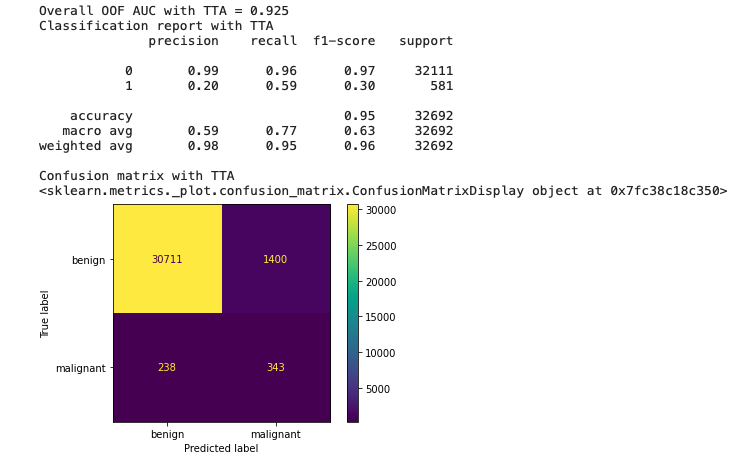
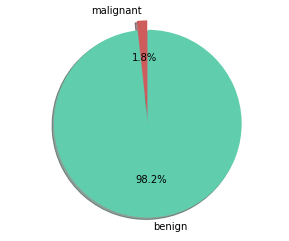
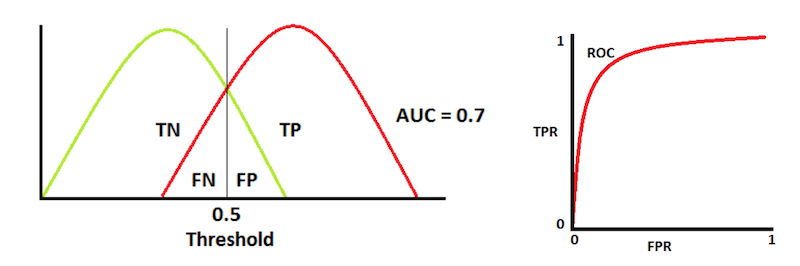
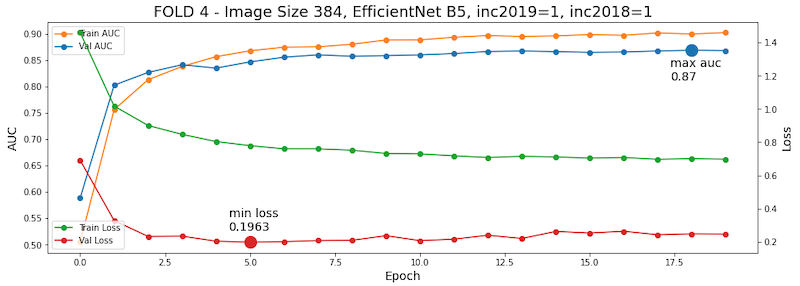
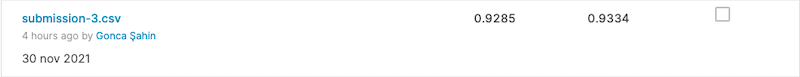
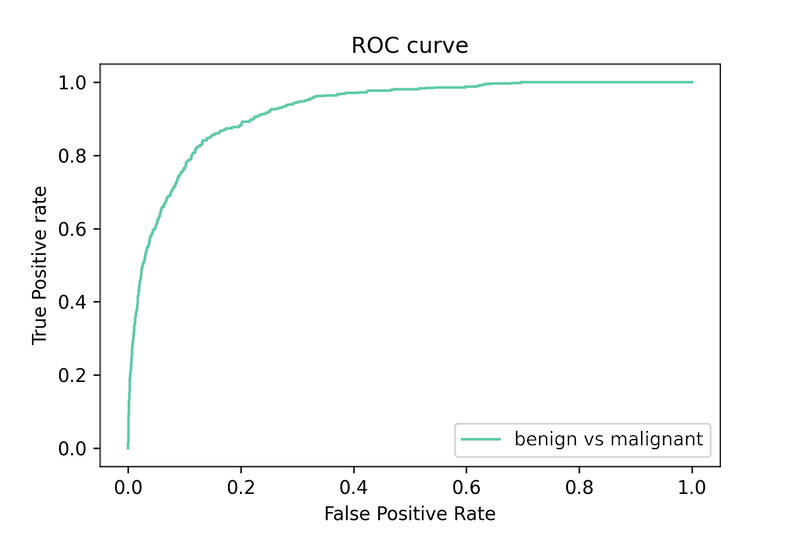
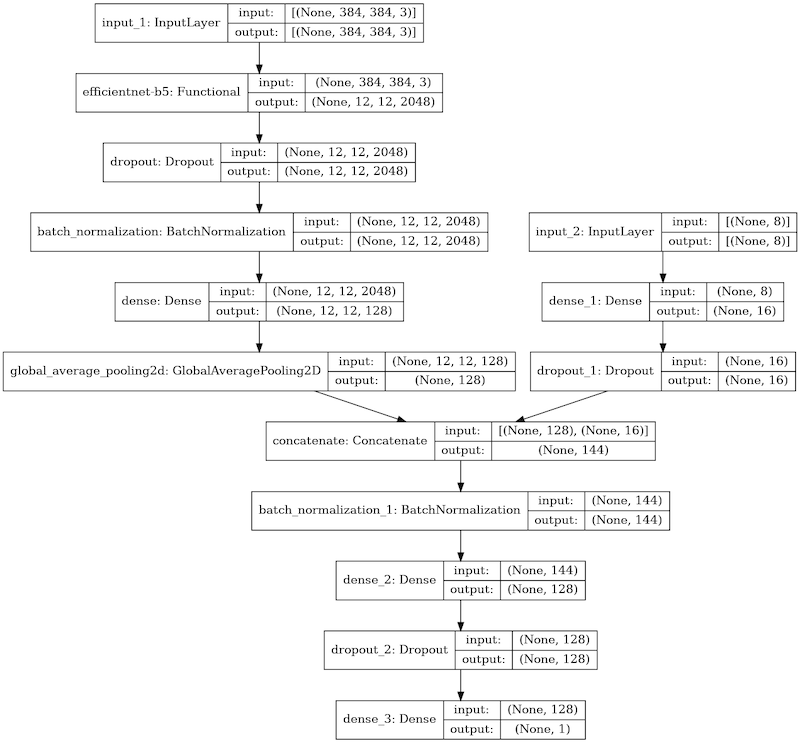
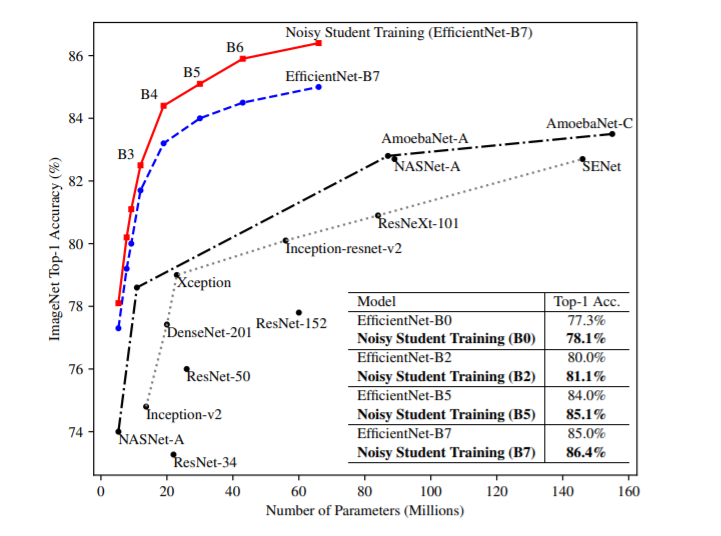
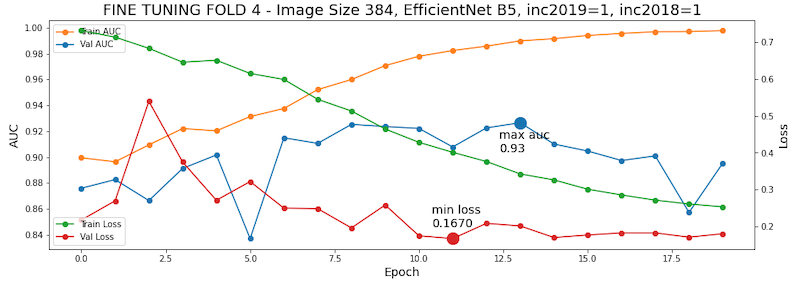

## After this summary, let's see how I obtained these results

Below are the examples of skin images with and without melanoma.
It doesn't seem possible to identify the images without a medical profession.

In [ ]:
import cv2, pandas as pd, matplotlib.pyplot as plt
train = pd.read_csv('../input/siim-isic-melanoma-classification/train.csv')
print('Examples WITH Melanoma')
imgs = train.loc[train.target==1].sample(5).image_name.values
plt.figure(figsize=(20,8))
for i,k in enumerate(imgs):
    img = cv2.imread('../input/jpeg-melanoma-128x128/train/%s.jpg'%k)
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    plt.subplot(2,5,i+1); plt.axis('off')
    plt.imshow(img)
plt.show()
print('Examples WITHOUT Melanoma')
imgs = train.loc[train.target==0].sample(5).image_name.values
plt.figure(figsize=(20,8))
for i,k in enumerate(imgs):
    img = cv2.imread('../input/jpeg-melanoma-128x128/train/%s.jpg'%k)
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    plt.subplot(2,5,i+1); plt.axis('off')
    plt.imshow(img)
plt.show()

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing
import matplotlib.pyplot as plt # visualization

# Directory for dataset
train_csv_dir = "/kaggle/input/siim-isic-melanoma-classification/train.csv"
train_jpeg_dir = "/kaggle/input/siim-isic-melanoma-classification/jpeg/train/"

# Read datasets
train_features = pd.read_csv(train_csv_dir)
train_features.head()

In [ ]:
# Let's see the data types of the columns and if there are any null values in columns
print(train_features.info())

In [ ]:
print('Null values in anatom_site_general_challenge column: '+ str(train_features['anatom_site_general_challenge'].isna().sum()))
print('Null values in age column: '+ str(train_features['age_approx'].isna().sum()))
print('Null values in sex: '+ str(train_features['sex'].isna().sum()))

In [ ]:
print('Unique location classes:' + str(train_features['anatom_site_general_challenge'].unique()))
print('Unique sex classes:' + str(train_features['sex'].unique()))

In [ ]:
# Let's see the age histogram of malignant and benign cases

bins = np.linspace(0, 100, 100)
plt.hist((train_features['age_approx'][train_features['target']==0]), bins, color = 'mediumaquamarine', label='benign')
plt.legend(loc='upper right')
plt.show()
plt.savefig('hist_age_benign',dpi=300);

plt.hist((train_features['age_approx'][train_features['target']==1]), bins, color = 'indianred', label='malignant')
plt.legend(loc='upper right')
plt.show()
plt.savefig('hist_age_malignant',dpi=300);

In [ ]:
labels = 'malignant', 'benign'
explode = (0.1, 0)  # only explode 'malignant'

fig1, ax1 = plt.subplots()
ax1.pie([len(train_features[train_features['target']==1]), len(train_features[train_features['target']==0])], explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90, colors=['indianred','mediumaquamarine'] )
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()
plt.savefig('pie_chart');

# Triple Stratified KFold CV with TFRecords
## Initialize Environment

In [ ]:
!pip install -q efficientnet >> /dev/null
import pandas as pd, numpy as np
from kaggle_datasets import KaggleDatasets
import tensorflow as tf, re, math
import tensorflow.keras.backend as K
import efficientnet.tfkeras as efn
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score, confusion_matrix, ConfusionMatrixDisplay, classification_report, f1_score, roc_curve
import matplotlib.pyplot as plt

## Parameters
 
* DEVICE - is GPU or TPU
* SEED - a different seed produces a different triple stratified kfold split.
* FOLDS - number of folds. Best set to 3, 5, or 15 but can be any number between 2 and 15
* IMG_SIZES - is a Python list of length FOLDS. These are the image sizes to use each fold
* INC2019 - This includes the new half of the 2019 competition data. The second half of the 2019 data is the comp data from 2018 plus 2017
* INC2018 - This includes the second half of the 2019 competition data which is the comp data from 2018 plus 2017
* BATCH_SIZES - is a list of length FOLDS. These are batch sizes for each fold. For maximum speed, it is best to use the largest batch size your GPU or TPU allows.
* EPOCHS - is a list of length FOLDS. These are maximum epochs. Note that each fold, the best epoch model is saved and used. So if epochs is too large, it won't matter.
* EFF_NETS - is a list of length FOLDS. These are the EfficientNets to use each fold. The number refers to the B. So a number of `0` refers to EfficientNetB0, and `1` refers to EfficientNetB1, etc.
* WGTS - this should be `1/FOLDS` for each fold. This is the weight when ensembling the folds to predict the test set. If you want a weird ensemble, you can use different weights.
* TTA - test time augmentation. Each test image is randomly augmented and predicted TTA times and the average prediction is used. TTA is also applied to OOF(out of fold) during validation.

In [ ]:
DEVICE = "TPU" #or "GPU"

# USE DIFFERENT SEED FOR DIFFERENT STRATIFIED KFOLD
SEED = 7

# NUMBER OF FOLDS. USE 3, 5, OR 15 
FOLDS = 5

# WHICH IMAGE SIZES TO LOAD EACH FOLD
# CHOOSE 128, 192, 256, 384, 512, 768 
IMG_SIZES = [384,384,384,384,384]

# INCLUDE OLD COMP DATA? YES=1 NO=0
INC2019 = [1,1,1,1,1]
INC2018 = [1,1,1,1,1]

# BATCH SIZE AND EPOCHS
BATCH_SIZES = [64]*FOLDS
EPOCHS = [20]*FOLDS

# WHICH EFFICIENTNET B? TO USE
EFF_NETS = [5,5,5,5,5]

# WEIGHTS FOR FOLD MODELS WHEN PREDICTING TEST
WGTS = [1/FOLDS]*FOLDS

# TEST TIME AUGMENTATION STEPS
TTA = 11

In [ ]:
if DEVICE == "TPU":
    print("connecting to TPU...")
    try:
        tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
        print('Running on TPU ', tpu.master())
    except ValueError:
        print("Could not connect to TPU")
        tpu = None

    if tpu:
        try:
            print("initializing  TPU ...")
            tf.config.experimental_connect_to_cluster(tpu)
            tf.tpu.experimental.initialize_tpu_system(tpu)
            strategy = tf.distribute.experimental.TPUStrategy(tpu)
            print("TPU initialized")
        except _:
            print("failed to initialize TPU")
    else:
        DEVICE = "GPU"

if DEVICE != "TPU":
    print("Using default strategy for CPU and single GPU")
    strategy = tf.distribute.get_strategy()

if DEVICE == "GPU":
    print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
    

AUTO     = tf.data.experimental.AUTOTUNE
REPLICAS = strategy.num_replicas_in_sync
print(f'REPLICAS: {REPLICAS}')

# Step 1: Preprocess
Preprocess has already been done and saved to TFRecords thanks to the starter notebook. Let's get the files.

In [ ]:
GCS_PATH = [None]*FOLDS; GCS_PATH2 = [None]*FOLDS
for i,k in enumerate(IMG_SIZES):
    GCS_PATH[i] = KaggleDatasets().get_gcs_path('melanoma-%ix%i'%(k,k))
    GCS_PATH2[i] = KaggleDatasets().get_gcs_path('isic2019-%ix%i'%(k,k))
files_train = np.sort(np.array(tf.io.gfile.glob(GCS_PATH[0] + '/train*.tfrec')))
files_test  = np.sort(np.array(tf.io.gfile.glob(GCS_PATH[0] + '/test*.tfrec')))

# Step 2: Data Augmentation
Rotation, sheer, zoom and shift augmentation are used, which were first shown in this notebook [here][1] and successfully used in Melanoma comp by AgentAuers [here][2]. This notebook also uses horizontal flip, hue, saturation, contrast, brightness augmentation similar to last years winner and also similar to AgentAuers' notebook.

[1]: https://www.kaggle.com/cdeotte/rotation-augmentation-gpu-tpu-0-96
[2]: https://www.kaggle.com/agentauers/incredible-tpus-finetune-effnetb0-b6-at-once


In [ ]:
ROT_ = 180.0
SHR_ = 2.0
HZOOM_ = 8.0
WZOOM_ = 8.0
HSHIFT_ = 8.0
WSHIFT_ = 8.0

In [ ]:
def get_mat(rotation, shear, height_zoom, width_zoom, height_shift, width_shift):
    # returns 3x3 transformmatrix which transforms indicies
        
    # CONVERT DEGREES TO RADIANS
    rotation = math.pi * rotation / 180.
    shear    = math.pi * shear    / 180.

    def get_3x3_mat(lst):
        return tf.reshape(tf.concat([lst],axis=0), [3,3])
    
    # ROTATION MATRIX
    c1   = tf.math.cos(rotation)
    s1   = tf.math.sin(rotation)
    one  = tf.constant([1],dtype='float32')
    zero = tf.constant([0],dtype='float32')
    
    rotation_matrix = get_3x3_mat([c1,   s1,   zero, 
                                   -s1,  c1,   zero, 
                                   zero, zero, one])    
    # SHEAR MATRIX
    c2 = tf.math.cos(shear)
    s2 = tf.math.sin(shear)    
    
    shear_matrix = get_3x3_mat([one,  s2,   zero, 
                                zero, c2,   zero, 
                                zero, zero, one])        
    # ZOOM MATRIX
    zoom_matrix = get_3x3_mat([one/height_zoom, zero,           zero, 
                               zero,            one/width_zoom, zero, 
                               zero,            zero,           one])    
    # SHIFT MATRIX
    shift_matrix = get_3x3_mat([one,  zero, height_shift, 
                                zero, one,  width_shift, 
                                zero, zero, one])
    
    return K.dot(K.dot(rotation_matrix, shear_matrix), 
                 K.dot(zoom_matrix,     shift_matrix))


def transform(image, DIM=384):    
    # input image - is one image of size [dim,dim,3] not a batch of [b,dim,dim,3]
    # output - image randomly rotated, sheared, zoomed, and shifted
    XDIM = DIM%2 #fix for size 331
    
    rot = ROT_ * tf.random.normal([1], dtype='float32')
    shr = SHR_ * tf.random.normal([1], dtype='float32') 
    h_zoom = 1.0 + tf.random.normal([1], dtype='float32') / HZOOM_
    w_zoom = 1.0 + tf.random.normal([1], dtype='float32') / WZOOM_
    h_shift = HSHIFT_ * tf.random.normal([1], dtype='float32') 
    w_shift = WSHIFT_ * tf.random.normal([1], dtype='float32') 

    # GET TRANSFORMATION MATRIX
    m = get_mat(rot,shr,h_zoom,w_zoom,h_shift,w_shift) 

    # LIST DESTINATION PIXEL INDICES
    x   = tf.repeat(tf.range(DIM//2, -DIM//2,-1), DIM)
    y   = tf.tile(tf.range(-DIM//2, DIM//2), [DIM])
    z   = tf.ones([DIM*DIM], dtype='int32')
    idx = tf.stack( [x,y,z] )
    
    # ROTATE DESTINATION PIXELS ONTO ORIGIN PIXELS
    idx2 = K.dot(m, tf.cast(idx, dtype='float32'))
    idx2 = K.cast(idx2, dtype='int32')
    idx2 = K.clip(idx2, -DIM//2+XDIM+1, DIM//2)
    
    # FIND ORIGIN PIXEL VALUES           
    idx3 = tf.stack([DIM//2-idx2[0,], DIM//2-1+idx2[1,]])
    d    = tf.gather_nd(image, tf.transpose(idx3))
        
    return tf.reshape(d,[DIM, DIM,3])

Not only the images but also the metadata was extracted from the data records.

In [ ]:
def read_labeled_tfrecord(example):
    tfrec_format = {
        'image'                        : tf.io.FixedLenFeature([], tf.string),
        'image_name'                   : tf.io.FixedLenFeature([], tf.string),
        'patient_id'                   : tf.io.FixedLenFeature([], tf.int64),
        'sex'                          : tf.io.FixedLenFeature([], tf.int64),
        'age_approx'                   : tf.io.FixedLenFeature([], tf.int64),
        'anatom_site_general_challenge': tf.io.FixedLenFeature([], tf.int64),
        'diagnosis'                    : tf.io.FixedLenFeature([], tf.int64),
        'target'                       : tf.io.FixedLenFeature([], tf.int64)
    }           
    example = tf.io.parse_single_example(example, tfrec_format)
    one_hot_site = tf.reshape(tf.one_hot(example['anatom_site_general_challenge'], 6), [1,6])
    age_min = 0
    age_max = 100
    age = tf.reshape(tf.cast((example['age_approx']-age_min)/(age_max-age_min), tf.float32), [1,1])
    sex = tf.reshape(tf.cast(example['sex'], tf.float32), [1,1])
    features = tf.reshape(tf.concat([sex, age, one_hot_site], axis=1), [8])
                                          
    return example['image'], features, example['target']

def read_unlabeled_tfrecord(example, return_image_name):
    tfrec_format = {
        'image'                        : tf.io.FixedLenFeature([], tf.string),
        'image_name'                   : tf.io.FixedLenFeature([], tf.string),
        'sex'                          : tf.io.FixedLenFeature([], tf.int64),
        'age_approx'                   : tf.io.FixedLenFeature([], tf.int64),
        'anatom_site_general_challenge': tf.io.FixedLenFeature([], tf.int64),
    }
    example = tf.io.parse_single_example(example, tfrec_format)
    one_hot_site = tf.reshape(tf.one_hot(example['anatom_site_general_challenge'], 6), [1,6])
    age_min = 0
    age_max = 100
    age = tf.reshape(tf.cast((example['age_approx']-age_min)/(age_max-age_min), tf.float32), [1,1])
    sex = tf.reshape(tf.cast(example['sex'], tf.float32), [1,1])
    features = tf.reshape(tf.concat([sex, age, one_hot_site], axis=1), [8])
                                          
    return example['image'], features, example['image_name'] if return_image_name else 0

 
def prepare_image(img, augment=True, dim=384):    
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.cast(img, tf.float32) / 255.0
    
    if augment:
        img = transform(img,DIM=dim)
        img = tf.image.random_flip_left_right(img)
        #img = tf.image.random_hue(img, 0.01)
        img = tf.image.random_saturation(img, 0.7, 1.3)
        img = tf.image.random_contrast(img, 0.8, 1.2)
        img = tf.image.random_brightness(img, 0.1)
                      
    img = tf.reshape(img, [dim,dim, 3])
            
    return img

    

def count_data_items(filenames):
    n = [int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) 
         for filename in filenames]
    return np.sum(n)

In [ ]:
def get_dataset(files, augment = False, shuffle = False, repeat = False, 
                labeled=True, return_image_names=True, batch_size=16, dim=384):
    
    ds = tf.data.TFRecordDataset(files, num_parallel_reads=AUTO)
    ds = ds.cache()
    
    
    if repeat:
        ds = ds.repeat()
    
    if shuffle: 
        ds = ds.shuffle(1024*8)
        opt = tf.data.Options()
        opt.experimental_deterministic = False
        ds = ds.with_options(opt)
        
    if labeled: 
        ds = ds.map(read_labeled_tfrecord, num_parallel_calls=AUTO)
    else:
        ds = ds.map(lambda example: read_unlabeled_tfrecord(example, return_image_names), 
                    num_parallel_calls=AUTO)      
    
    ds = ds.map(lambda img, features, imgname_or_label: ((prepare_image(img, augment=augment, dim=dim), features), imgname_or_label), 
                    num_parallel_calls=AUTO)
    
    
    ds = ds.batch(batch_size * REPLICAS)
    ds = ds.prefetch(AUTO)
    return ds

# Step 3: Build Model
Model architecture based on a combination of an EfficientNet model used for transfer learning and a simple model based on the metadata. After applying a dense layer and dropout on metadata, I concatenate these two branchs at the end of the model and apply a last dense layer, batch normalization and dropout layers before classification. I also used fine tuning process in transfer learning. After epochs with frozen layers, I unfreezes the layers excluding the batch normalization layers as advised in Keras tutorial since it may reduce accuracy. Then I continued training for another 20 epochs.

In [ ]:
EFNS = [efn.EfficientNetB0, efn.EfficientNetB1, efn.EfficientNetB2, efn.EfficientNetB3, 
        efn.EfficientNetB4, efn.EfficientNetB5, efn.EfficientNetB6,  efn.EfficientNetB7]

noisy_student = ["../input/efficientnet-noisy-student-keras-applications/efficientnetb0_notop.h5",
                 "../input/efficientnet-noisy-student-keras-applications/efficientnetb1_notop.h5",
                 "../input/efficientnet-noisy-student-keras-applications/efficientnetb2_notop.h5",
                 "../input/efficientnet-noisy-student-keras-applications/efficientnetb3_notop.h5",
                 "../input/efficientnet-noisy-student-keras-applications/efficientnetb4_notop.h5",
                 "../input/efficientnet-noisy-student-keras-applications/efficientnetb5_notop.h5",
                 "../input/efficientnet-noisy-student-keras-applications/efficientnetb6_notop.h5",
                 "../input/efficientnet-noisy-student-keras-applications/efficientnetb7_notop.h5"]
                 
def build_model(dim=384, ef=5):
    input_image = tf.keras.layers.Input(shape=(dim,dim,3))
    input_features = tf.keras.layers.Input(shape=(8))
    
    base = EFNS[ef](input_shape=(dim,dim,3),include_top=False)
    base.load_weights(noisy_student[ef], by_name=True)
    base.trainable = False
    
    x = base(input_image, training=False)
    x = tf.keras.layers.Dropout(0.3)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dense(units = 128, activation="relu")(x)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    
    # Train the feature map with a shallow dense layer
    x2 = tf.keras.layers.Dense(units = 16, activation="relu")(input_features)
    x2 = tf.keras.layers.Dropout(0.3)(x2)

    # concatenate outputs of two branches
    x = tf.keras.layers.concatenate([x, x2])
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dense(units = 128, activation="relu")(x) 
    x = tf.keras.layers.Dropout(0.5)(x)

    # make predictions
    x = tf.keras.layers.Dense(1,activation='sigmoid')(x)
    model = tf.keras.Model(inputs = [input_image, input_features],outputs=x)
    opt = tf.keras.optimizers.Adam(learning_rate=0.00005)
    loss = tf.keras.losses.BinaryCrossentropy(label_smoothing=0.05) 
    model.compile(optimizer=opt,loss=loss,metrics=['AUC'])
    return model

In [ ]:
plot_model = build_model(dim=384, ef=5)
plot_model.summary()
tf.keras.utils.plot_model(plot_model, to_file="plot_model.png", show_shapes=True)

# Step 4: Train Schedule
This is a common train schedule for transfer learning. The learning rate starts near zero, then increases to a maximum, then decays over time. 

In [ ]:
def get_lr_callback(batch_size=8):
    lr_start   = 0.000005
    lr_max     = 0.00000125 * REPLICAS * batch_size
    lr_min     = 0.000001
    lr_ramp_ep = 5
    lr_sus_ep  = 0
    lr_decay   = 0.8
   
    def lrfn(epoch):
        if epoch < lr_ramp_ep:
            lr = (lr_max - lr_start) / lr_ramp_ep * epoch + lr_start
            
        elif epoch < lr_ramp_ep + lr_sus_ep:
            lr = lr_max
            
        else:
            lr = (lr_max - lr_min) * lr_decay**(epoch - lr_ramp_ep - lr_sus_ep) + lr_min
            
        return lr

    lr_callback = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose=False)
    return lr_callback

## Train Model
Our model will be trained for the number of FOLDS and EPOCHS choosen in the configuration above. Each fold the model with highest validation AUG will be saved and used to predict OOF and test.  

In [ ]:
# USE VERBOSE=0 for silent, VERBOSE=1 for interactive, VERBOSE=2 for commit
VERBOSE = 1
DISPLAY_PLOT = True

skf = KFold(n_splits=FOLDS,shuffle=True,random_state=SEED)
oof_pred = []; oof_tar = []; oof_val = []; oof_names = []; oof_folds = [] 
preds = np.zeros((count_data_items(files_test),1))

for fold,(idxT,idxV) in enumerate(skf.split(np.arange(15))):
    
    # DISPLAY FOLD INFO
    if DEVICE=='TPU':
        if tpu: tf.tpu.experimental.initialize_tpu_system(tpu)
    print('#'*25); print('#### FOLD',fold+1)
    print('#### Image Size %i with EfficientNet B%i and batch_size %i'%
          (IMG_SIZES[fold],EFF_NETS[fold],BATCH_SIZES[fold]*REPLICAS))
    
    # CREATE TRAIN AND VALIDATION SUBSETS
    files_train = tf.io.gfile.glob([GCS_PATH[fold] + '/train%.2i*.tfrec'%x for x in idxT])
    if INC2019[fold]:
        files_train += tf.io.gfile.glob([GCS_PATH2[fold] + '/train%.2i*.tfrec'%x for x in idxT*2+1])
        print('#### Using 2019 external data')
    if INC2018[fold]:
        files_train += tf.io.gfile.glob([GCS_PATH2[fold] + '/train%.2i*.tfrec'%x for x in idxT*2])
        print('#### Using 2018+2017 external data')
    np.random.shuffle(files_train); print('#'*25)
    files_valid = tf.io.gfile.glob([GCS_PATH[fold] + '/train%.2i*.tfrec'%x for x in idxV])
    files_test = np.sort(np.array(tf.io.gfile.glob(GCS_PATH[fold] + '/test*.tfrec')))
    
    # BUILD MODEL
    K.clear_session()
    with strategy.scope():
        model = build_model(dim=IMG_SIZES[fold],ef=EFF_NETS[fold])
        
    # SAVE BEST MODEL EACH FOLD
    sv = tf.keras.callbacks.ModelCheckpoint(
        'fold-%i.h5'%fold, monitor='val_auc', verbose=0, save_best_only=True,
        save_weights_only=False, mode='max', save_freq='epoch')
   
    # TRAIN
    print('Training...')
    history = model.fit(
        get_dataset(files_train, augment=True, shuffle=True, repeat=True,
                dim=IMG_SIZES[fold], batch_size = BATCH_SIZES[fold]), 
        epochs=EPOCHS[fold], callbacks = [sv,get_lr_callback(BATCH_SIZES[fold])],
        steps_per_epoch=count_data_items(files_train)/BATCH_SIZES[fold]//REPLICAS,
        validation_data=get_dataset(files_valid,augment=False,shuffle=False,
                repeat=False,dim=IMG_SIZES[fold]), class_weight = {0:1,1:8},
        verbose=VERBOSE
    )
    
    # PLOT TRAINING
    if DISPLAY_PLOT:
        plt.figure(figsize=(15,5))
        plt.plot(np.arange(EPOCHS[fold]),history.history['auc'],'-o',label='Train AUC',color='#ff7f0e')
        plt.plot(np.arange(EPOCHS[fold]),history.history['val_auc'],'-o',label='Val AUC',color='#1f77b4')
        x = np.argmax( history.history['val_auc'] ); y = np.max( history.history['val_auc'] )
        xdist = plt.xlim()[1] - plt.xlim()[0]; ydist = plt.ylim()[1] - plt.ylim()[0]
        plt.scatter(x,y,s=200,color='#1f77b4'); plt.text(x-0.03*xdist,y-0.13*ydist,'max auc\n%.2f'%y,size=14)
        plt.ylabel('AUC',size=14); plt.xlabel('Epoch',size=14)
        plt.legend(loc=2)
        plt2 = plt.gca().twinx()
        plt2.plot(np.arange(EPOCHS[fold]),history.history['loss'],'-o',label='Train Loss',color='#2ca02c')
        plt2.plot(np.arange(EPOCHS[fold]),history.history['val_loss'],'-o',label='Val Loss',color='#d62728')
        x = np.argmin( history.history['val_loss'] ); y = np.min( history.history['val_loss'] )
        ydist = plt.ylim()[1] - plt.ylim()[0]
        plt.scatter(x,y,s=200,color='#d62728'); plt.text(x-0.03*xdist,y+0.05*ydist,'min loss\n%.4f'%y,size=14)
        plt.ylabel('Loss',size=14)
        plt.title('FOLD %i - Image Size %i, EfficientNet B%i, inc2019=%i, inc2018=%i'%
                (fold+1,IMG_SIZES[fold],EFF_NETS[fold],INC2019[fold],INC2018[fold]),size=18)
        plt.legend(loc=3)
        plt.show()
    
    # FINE TUNING TRAIN
    def unfreeze_model(model):
        # We unfreeze the layers while leaving BatchNorm layers frozen
        for layer in model.layers[:]:
            if not isinstance(layer, tf.keras.layers.BatchNormalization):
                layer.trainable = True
                
    print('Loading best model...')            
    model.load_weights('fold-%i.h5'%fold)        
    unfreeze_model(model)
    opt = tf.keras.optimizers.Adam(learning_rate=1e-5)
    loss = tf.keras.losses.BinaryCrossentropy(label_smoothing=0.05) 
    model.compile(
        optimizer=opt, loss=loss, metrics=["AUC"])
    
    print('Fine tuning training...')
    history = model.fit(
        get_dataset(files_train, augment=True, shuffle=True, repeat=True,
                dim=IMG_SIZES[fold], batch_size = BATCH_SIZES[fold]), 
        epochs=EPOCHS[fold], callbacks = [sv,get_lr_callback(BATCH_SIZES[fold])], 
        steps_per_epoch=count_data_items(files_train)/BATCH_SIZES[fold]//REPLICAS,
        validation_data=get_dataset(files_valid,augment=False,shuffle=False,
                repeat=False,dim=IMG_SIZES[fold]), class_weight = {0:1,1:8},
        verbose=VERBOSE)
    
    # PLOT FINE TUNING TRAINING
    if DISPLAY_PLOT:
        plt.figure(figsize=(15,5))
        plt.plot(np.arange(EPOCHS[fold]),history.history['auc'],'-o',label='Train AUC',color='#ff7f0e')
        plt.plot(np.arange(EPOCHS[fold]),history.history['val_auc'],'-o',label='Val AUC',color='#1f77b4')
        x = np.argmax( history.history['val_auc'] ); y = np.max( history.history['val_auc'] )
        xdist = plt.xlim()[1] - plt.xlim()[0]; ydist = plt.ylim()[1] - plt.ylim()[0]
        plt.scatter(x,y,s=200,color='#1f77b4'); plt.text(x-0.03*xdist,y-0.13*ydist,'max auc\n%.2f'%y,size=14)
        plt.ylabel('AUC',size=14); plt.xlabel('Epoch',size=14)
        plt.legend(loc=2)
        plt2 = plt.gca().twinx()
        plt2.plot(np.arange(EPOCHS[fold]),history.history['loss'],'-o',label='Train Loss',color='#2ca02c')
        plt2.plot(np.arange(EPOCHS[fold]),history.history['val_loss'],'-o',label='Val Loss',color='#d62728')
        x = np.argmin( history.history['val_loss'] ); y = np.min( history.history['val_loss'] )
        ydist = plt.ylim()[1] - plt.ylim()[0]
        plt.scatter(x,y,s=200,color='#d62728'); plt.text(x-0.03*xdist,y+0.05*ydist,'min loss\n%.4f'%y,size=14)
        plt.ylabel('Loss',size=14)
        plt.title('FINE TUNING FOLD %i - Image Size %i, EfficientNet B%i, inc2019=%i, inc2018=%i'%
                (fold+1,IMG_SIZES[fold],EFF_NETS[fold],INC2019[fold],INC2018[fold]),size=18)
        plt.legend(loc=3)
        plt.show()
    
    print('Loading best model...')
    model.load_weights('fold-%i.h5'%fold)
    
    # PREDICT OOF USING TTA
    print('Predicting OOF with TTA...')
    ds_valid = get_dataset(files_valid,labeled=False,return_image_names=False,augment=True,
            repeat=True,shuffle=False,dim=IMG_SIZES[fold],batch_size=BATCH_SIZES[fold]*4)
    ct_valid = count_data_items(files_valid); STEPS = TTA * ct_valid/BATCH_SIZES[fold]/4/REPLICAS
    pred = model.predict(ds_valid,steps=STEPS,verbose=VERBOSE)[:TTA*ct_valid,] 
    oof_pred.append( np.mean(pred.reshape((ct_valid,TTA),order='F'),axis=1) )                 
    #oof_pred.append(model.predict(get_dataset(files_valid,dim=IMG_SIZES[fold]),verbose=1))
    
    # GET OOF TARGETS AND NAMES
    ds_valid = get_dataset(files_valid, augment=False, repeat=False, dim=IMG_SIZES[fold],
            labeled=True, return_image_names=True)
    oof_tar.append( np.array([target.numpy() for img, target in iter(ds_valid.unbatch())]) )
    oof_folds.append( np.ones_like(oof_tar[-1],dtype='int8')*fold )
    ds = get_dataset(files_valid, augment=False, repeat=False, dim=IMG_SIZES[fold],
                labeled=False, return_image_names=True)
    oof_names.append( np.array([img_name.numpy().decode("utf-8") for img, img_name in iter(ds.unbatch())]))
    
    # PREDICT TEST USING TTA
    print('Predicting Test with TTA...')
    ds_test = get_dataset(files_test,labeled=False,return_image_names=False,augment=True,
            repeat=True,shuffle=False,dim=IMG_SIZES[fold],batch_size=BATCH_SIZES[fold]*4)
    ct_test = count_data_items(files_test); STEPS = TTA * ct_test/BATCH_SIZES[fold]/4/REPLICAS
    pred = model.predict(ds_test,steps=STEPS,verbose=VERBOSE)[:TTA*ct_test,] 
    preds[:,0] += np.mean(pred.reshape((ct_test,TTA),order='F'),axis=1) * WGTS[fold]
    
    # REPORT RESULTS
    y_pred = [1 if x >= 0.5 else 0 for x in oof_pred[-1]]
    cm = confusion_matrix(oof_tar[-1], y_pred)
    print('with TTA')
    classification_report(oof_tar[-1], y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels = ['benign', 'malignant']).plot()
    disp.plot()
    plt.show()
    
    auc = roc_auc_score(oof_tar[-1],oof_pred[-1])
    oof_val.append(np.max( history.history['val_auc'] ))
    print('#### FOLD %i OOF AUC without TTA = %.3f, with TTA = %.3f'%(fold+1,oof_val[-1],auc))
    


## Calculate OOF AUC
The OOF (out of fold) predictions are saved to disk. 

In [ ]:
# COMPUTE OVERALL OOF AUC
oof = np.concatenate(oof_pred); true = np.concatenate(oof_tar);
names = np.concatenate(oof_names); folds = np.concatenate(oof_folds)
auc = roc_auc_score(true,oof)
print('Overall OOF AUC with TTA = %.3f'%auc)

# PLOT CLASSIFICATION REPORT AND CONFUSION MATRIX
y_pred = [1 if x >= 0.5 else 0 for x in oof]
print('Classification report with TTA')
print(classification_report(true, y_pred))
        
cm = confusion_matrix(true, y_pred)
print('Confusion matrix with TTA')
print(ConfusionMatrixDisplay(confusion_matrix=cm, display_labels = ['benign', 'malignant']).plot())

In [ ]:
# SAVE OOF TO DISK
df_oof = pd.DataFrame(dict(
    image_name = names, target=true, pred = oof, fold=folds))
df_oof.to_csv('oof.csv',index=False)
df_oof.head()

In [ ]:
oof = pd.read_csv('../input/triple-stratified-kfold-with-tfrecords/oof.csv')
oof.head()

In [ ]:
 fpr, tpr, thresh = roc_curve(oof['target'], oof['pred'], pos_label=1)
    
# plotting    
plt.plot(fpr, tpr, linestyle='solid',color='mediumaquamarine', label='benign vs malignant')
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='best')
plt.savefig('Binary_ROC',dpi=300);

# Submit To Kaggle

In [ ]:
ds = get_dataset(files_test, augment=False, repeat=False, dim=IMG_SIZES[fold],
                 labeled=False, return_image_names=True)

image_names = np.array([img_name.numpy().decode("utf-8") 
                        for img, img_name in iter(ds.unbatch())])

In [ ]:
submission = pd.DataFrame(dict(image_name=image_names, target=preds[:,0]))
submission = submission.sort_values('image_name') 
submission.to_csv('submission.csv', index=False)
submission.head()